In [1]:
import sys
import pickle

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from libemg.utils import get_windows

sys.path.append('../')
from lift.simulator.simulator import WindowSimulator
from lift.datasets import get_mad_sample
from configs import BaseConfig
config = BaseConfig()

In [2]:
data_path = '../datasets/MyoArmbandDataset/PreTrainingDataset/Female0/training0/'
sim = WindowSimulator(num_actions=5, num_bursts=1, num_channels=8, window_size=200)
sim.fit_params_to_mad_sample(data_path)

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/libemg/utils.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(windows, dtype=torch.float32)


In [3]:
emg_list, label_list = get_mad_sample(data_path, filter_labels = True)
sort_id = np.argsort(label_list)
label_list = [label_list[i] for i in sort_id]
emg_list = [emg_list[i] for i in sort_id]
# I used labels 0 - 4 (including 4), where label 0 is rest

min_len = min([len(emg) for emg in emg_list])
short_emgs = [emg[:min_len,:] for emg in emg_list]
windows_list = [get_windows(s_emg, 200, 200, as_tensor=True) for s_emg in short_emgs]
windows = torch.stack(windows_list, dim=0)
n_repeats = windows_list[0].shape[0]

short_labels = torch.tensor([np.repeat(label, repeats=n_repeats) for label in label_list])
actions = F.one_hot(short_labels, num_classes=5).float()

flat_actions = actions.flatten(start_dim=0, end_dim=1)
flat_windows = windows.flatten(start_dim=0, end_dim=1)

In [4]:
sim_windows = sim(flat_actions)

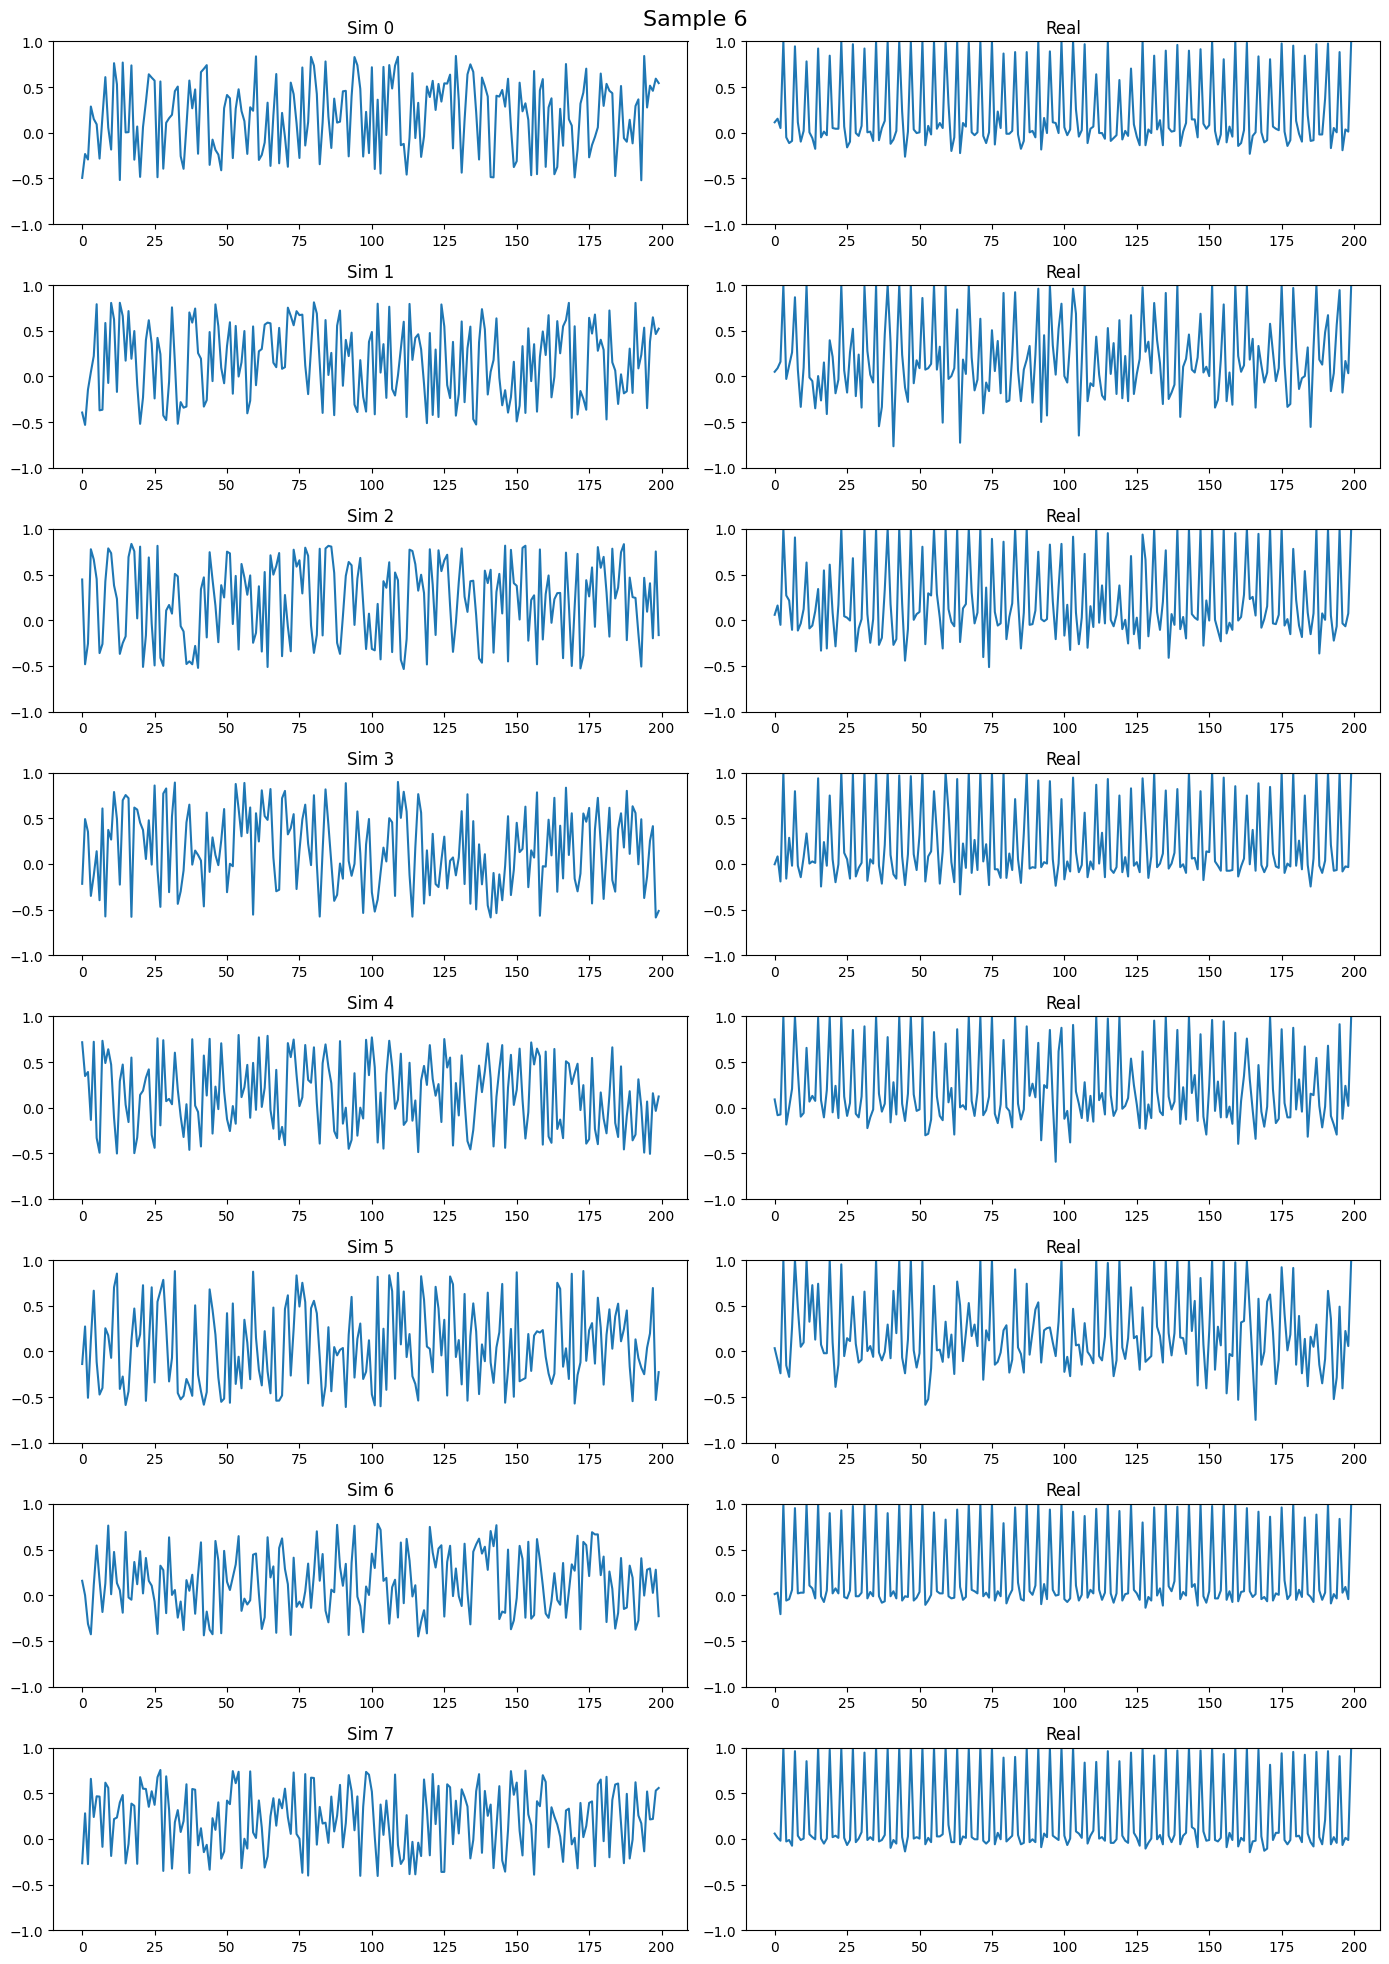

In [17]:
sample_idx = 6
n_channels = 8
fig, axs = plt.subplots(n_channels,2, figsize=(14,20))
for channel_idx in range(n_channels):
    axs[channel_idx,0].plot(sim_windows[sample_idx,channel_idx,:])
    axs[channel_idx,0].set_title(f'Sim {channel_idx}')
    axs[channel_idx,0].set_ylim(-1, 1)
    axs[channel_idx,1].plot(flat_windows[sample_idx,channel_idx,:])
    axs[channel_idx,1].set_title('Real')
    axs[channel_idx,1].set_ylim(-1, 1)
fig.suptitle(f'Sample {sample_idx}', fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
from libemg.feature_extractor import FeatureExtractor

def get_features(windows):
    fe = FeatureExtractor()
    feature_list = ['MAV', 'SSC', 'ZC', 'WL']
    features = fe.extract_features(feature_list, windows)
    features = np.stack(list(features.values()), axis=-1)
    return features

In [28]:
features = get_features(flat_windows.numpy())
sim_features = get_features(sim_windows.numpy())

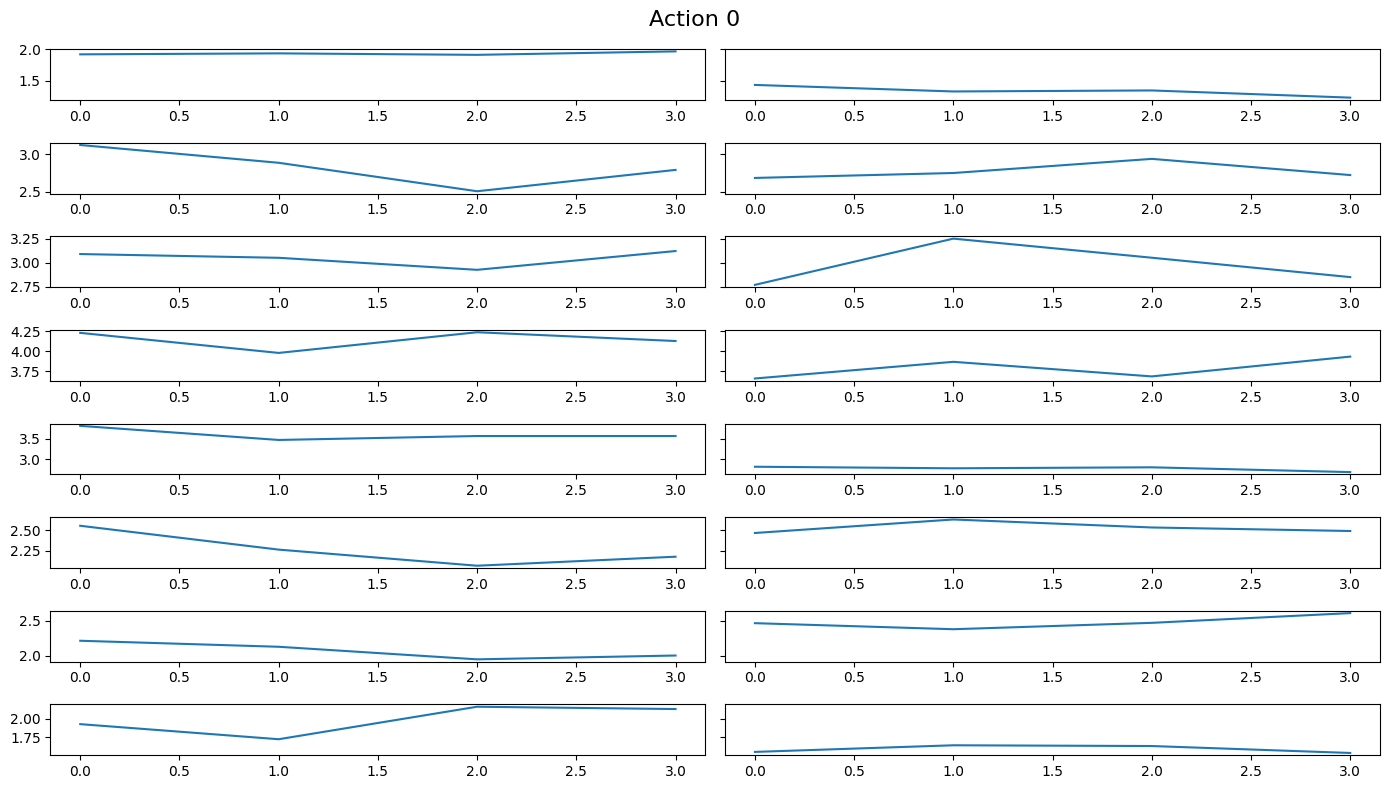

In [34]:
n_consec_samples = 4
n_action = 0
n_channels = 8
feat_idx = 3

s_idx = n_action * n_consec_samples
e_idx = (n_action + 1) * n_consec_samples

action_features = features[s_idx:e_idx]
sim_action_features = sim_features[s_idx:e_idx]

fig, axs = plt.subplots(n_channels, 2, figsize=(14,8), sharey='row')
for channel_idx in range(n_channels):
    axs[channel_idx, 0].plot(action_features[:,channel_idx, feat_idx])
    axs[channel_idx, 1].plot(sim_action_features[:,channel_idx, feat_idx])
fig.suptitle(f'Action {n_action}', fontsize=16)
plt.tight_layout()
plt.show()